In [1]:
%matplotlib widget

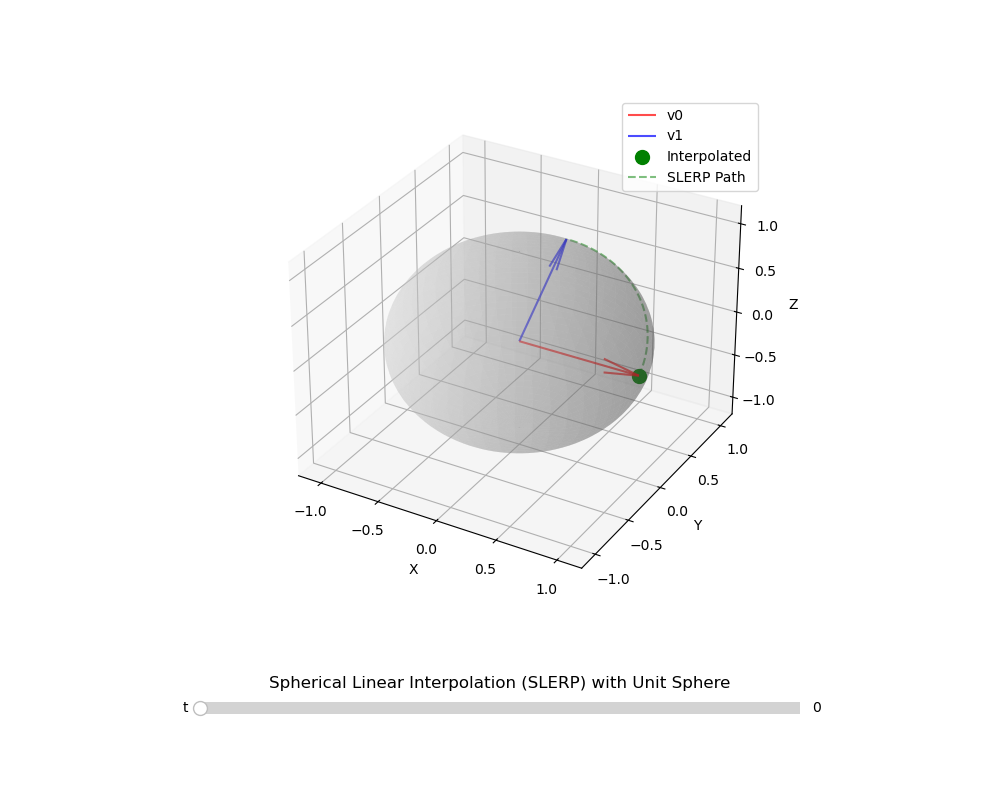

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Functions for SLERP
def lerp(t: float, v0: np.ndarray, v1: np.ndarray) -> np.ndarray:
    return (1 - t) * v0 + t * v1

def normalize(v: np.ndarray, eps: float):
    norm_v = np.linalg.norm(v)
    if norm_v > eps:
        v = v / norm_v
    return v

def slerp(
    t: float,
    v0: np.ndarray,
    v1: np.ndarray,
    DOT_THRESHOLD: float = 0.9995,
    eps: float = 1e-8,
):
    # Normalize the vectors to get the directions and angles
    v0_copy = np.copy(v0)
    v1_copy = np.copy(v1)

    v0 = normalize(v0, eps)
    v1 = normalize(v1, eps)

    # Dot product with the normalized vectors
    dot = np.sum(v0 * v1)

    # If absolute value of dot product is almost 1, vectors are ~colinear, so use lerp
    if np.abs(dot) > DOT_THRESHOLD:
        return lerp(t, v0_copy, v1_copy)

    # Calculate initial angle between v0 and v1
    theta_0 = np.arccos(dot)
    sin_theta_0 = np.sin(theta_0)

    # Angle at timestep t
    theta_t = theta_0 * t
    sin_theta_t = np.sin(theta_t)

    # Finish the slerp algorithm
    s0 = np.sin(theta_0 - theta_t) / sin_theta_0
    s1 = sin_theta_t / sin_theta_0
    
    return s0 * v0_copy + s1 * v1_copy

# Visualization
def visualize_slerp():
    # Create figure and 3D axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Define two 3D vectors
    v0 = np.array([1, 0, 0])  # Red vector
    v1 = np.array([0, 1, 1])  # Blue vector

    # Normalize v1
    v1 = v1 / np.linalg.norm(v1)

    # Initial interpolation (t=0)
    t_init = 0
    interpolated_point = slerp(t_init, v0, v1)

    # Plot unit sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(x, y, z, color='lightgray', alpha=0.3, edgecolor='none')

    # Plot starting vectors
    ax.quiver(0, 0, 0, v0[0], v0[1], v0[2], color='red', label='v0', alpha=0.7)
    ax.quiver(0, 0, 0, v1[0], v1[1], v1[2], color='blue', label='v1', alpha=0.7)

    # Plot interpolated point
    point_plot, = ax.plot([interpolated_point[0]], [interpolated_point[1]], 
                          [interpolated_point[2]], 'go', markersize=10, label='Interpolated')

    # Plot interpolation path (arc)
    # Generate multiple points along the arc
    t_points = np.linspace(0, 1, 50)
    arc_points = np.array([slerp(t, v0, v1) for t in t_points])
    arc_line, = ax.plot(arc_points[:, 0], arc_points[:, 1], arc_points[:, 2], 
                        color='green', linestyle='--', alpha=0.5, label='SLERP Path')

    # Set axis limits and labels
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_zlim([-1.2, 1.2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    
    # Add slider for t
    plt.subplots_adjust(bottom=0.25)
    ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
    t_slider = Slider(ax_slider, 't', 0.0, 1.0, valinit=t_init)

    # Update function for slider
    def update(val):
        t = t_slider.val
        new_point = slerp(t, v0, v1)
        
        # Update interpolated point
        point_plot.set_data([new_point[0]], [new_point[1]])
        point_plot.set_3d_properties([new_point[2]])
        
        fig.canvas.draw_idle()

    # Connect slider to update function
    t_slider.on_changed(update)

    plt.title('Spherical Linear Interpolation (SLERP) with Unit Sphere')
    plt.show()

# Run the visualization
visualize_slerp()